# Interpolation

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

from utils.plot import show_tensor_images, show_loss_graph

## Generator

In [2]:
class Generator(nn.Module):
    
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=(kernel_size, kernel_size), stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=(kernel_size, kernel_size), stride=stride),
                nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)


def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

## Restore generator from the checkpoint

In [3]:
z_dim = 64
device = "cuda"

checkpoint_path = "./checkpoints/DC_GAN.pt"

checkpoint = torch.load(checkpoint_path)

gen = Generator(z_dim).to(device)
gen.load_state_dict(checkpoint["gen"])
gen.eval()

del checkpoint

## Interpolation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


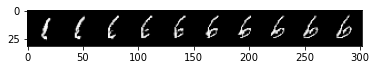

In [34]:
# Try running this multiple times, until some nice interpolation is generated
noise1 = get_noise(1, z_dim, device=device)
noise2 = get_noise(1, z_dim, device=device)

interpolation_percents = torch.linspace(0, 1, 10, device=device)[:, None]
interpolations = noise1 * (1 - interpolation_percents) + noise2 * interpolation_percents

fakes = gen(interpolations)
show_tensor_images(fakes, nrow=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


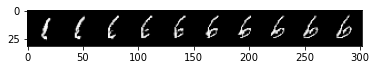

In [36]:
# Save generated interpolation
show_tensor_images(fakes, nrow=10, save_path="./figures/Interpolation_1_6.pdf")

## Cleanup

In [37]:
%reset